In [3]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import time
#from IPython.display import clear_output
from matplotlib import cm
from matplotlib import rc
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
import beam_modelling         as model
import handling_data          as hdata
import parameters_and_setting as parset
import plot_setting           as pset

#import pymaster as nmt

c        = 2*['black','gray','bisque','gold','darkorange','goldenrod','forestgreen','seagreen','lightseagreen','darkcyan','dodgerblue','blue','blueviolet','rebeccapurple','crimson','firebrick','orangered']
markers_ = 2*[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","x","X","D","d",0,1,2,3,4,5,6,7,8,9,10,11]


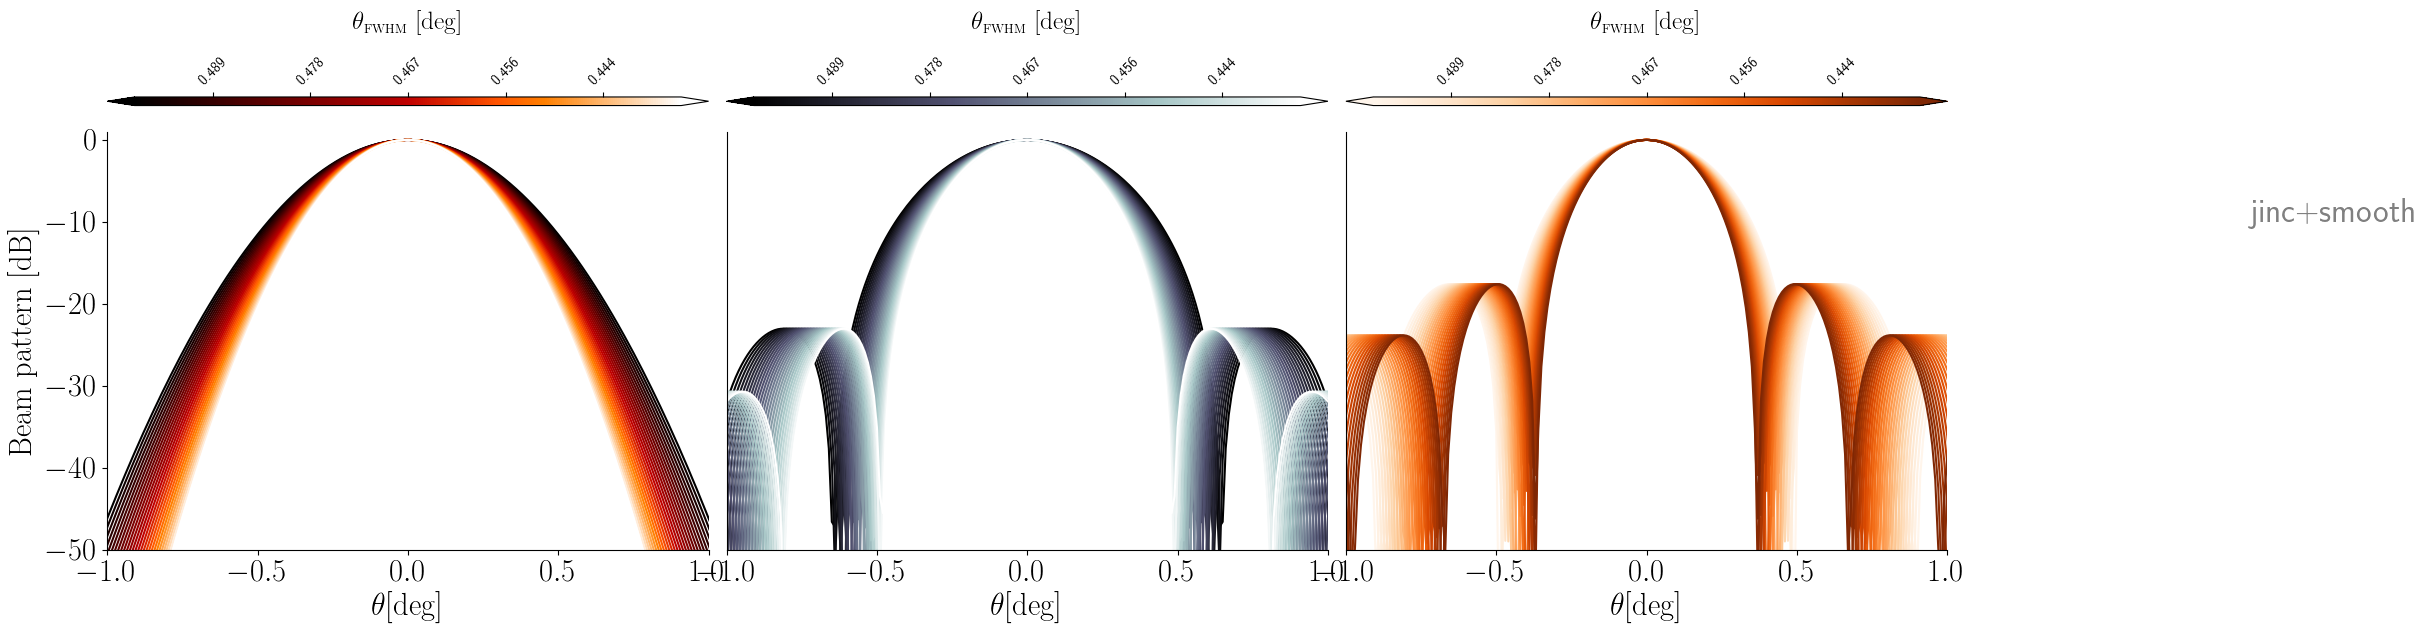

In [7]:
params = parset.params_standard()
theta = np.arange(-10,10+0.01,0.01)
params['xlims'] = [-1, 1]#[theta.min(),theta.max()]
nu    = np.arange(980,1260+10,10)
params['plot_add_text_true']= True
params['plot_add_text_x']   = 2
params['plot_add_text_y']   = -10
params['plot_add_text_size'] = 24
params['cbar_ticks_decimals']=3

D = 40
source = "meerkat" if D==13.5 else "bingo" if D==40. else "none"
fwhm_type = 'smooth'
fwhm = model.fwhm_modelling(nu=nu,type_=fwhm_type, D=D, in_degree=True)

grid = plt.GridSpec(1,3,top=1.2,right=3,wspace=0.03)

for k , (type_, icmap) in enumerate(zip(params['beam_model'],params['cmap_list'])):
    ax = plt.subplot(grid[0,k])
    params['k']   = k
    params['cmap']=icmap
    if k: params['disable_ytick']=True
    ######################
    #print(fwhm)
    for i,ifwhm in enumerate(fwhm):
        if not i:
            bg = model.beam_function(type_,fwhm=ifwhm, theta_=theta)
        else:
            bg = np.vstack((bg,model.beam_function(type_,fwhm=ifwhm, theta_=theta)))
    params['fwhm']=np.around(fwhm,decimals=1)
    bg = 10*np.log10(bg)
    params['n_lines'] = bg.shape[0]
    pset.colorbar_setting(params)
    for i,ibg in enumerate(bg):
        plt.plot(theta ,ibg, color=params['cmap'].to_rgba(i + 1),label="{:.2f}".format(fwhm[i]))
    pset.colorbar_customization(params=params)
    pset.plot_customization(ax=ax,params=params)
    params['plot_add_text'] = "+".join((type_,fwhm_type))
    pset.plot_add_text(params)
#plt.savefig("/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/outputs/{}.jpg".format('beam_fwhm_{}__{}'.format(fwhm_type,source)), dpi=100, bbox_inches='tight')

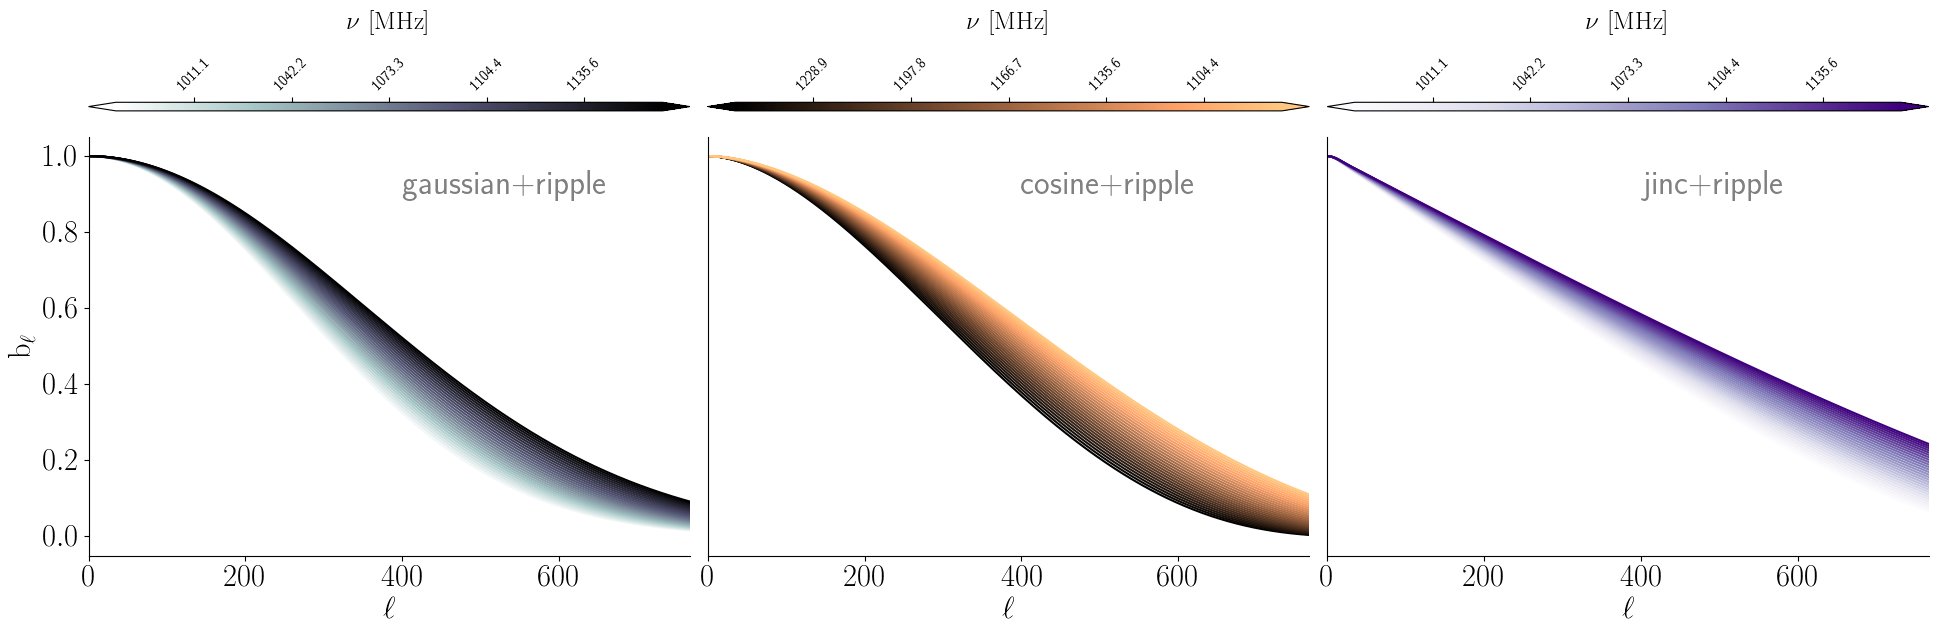

In [4]:
params = parset.params_standard()
params['xlims'] = [None,None]
params['ylims'] = [None,None]
params['cbar_ticks_scale_invert']=False
params['cbar_label'] = np.array(3*[r'$\nu\ [\textrm{MHz}]$'])
params['cbar_ticks_decimals']=1
params['ylabel']= np.array([r'$\textrm{b}_{\ell}$',None,None])
params['xlabel']= np.array(3*[r'$\ell$'])
params['beam_model'] = ['gaussian','cosine','jinc']
params['cmap_list']  = ['bone_r','copper','Purples']
params['plot_add_text_true']= True
params['plot_add_text_x']   = 400
params['plot_add_text_y']   = 0.9
params['plot_add_text_size'] = 24

D = 40
source = "meerkat" if D==13.5 else "bingo" if D==40. else "none"
fwhm_type="ripple"

nside = 512
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)
nu = np.arange(980,1260+10,10)
grid = plt.GridSpec(1,3,top=1.2,right=3*1.,wspace=0.03)
for k , (type_, icmap) in enumerate(zip(params['beam_model'],params['cmap_list'])):
    ax = plt.subplot(grid[0,k])
    if not k: params['disable_ytick']=False
    if k: params['disable_ytick']=True    
    if k==1: params['cbar_ticks_scale_invert']=True
    else:params['cbar_ticks_scale_invert']=False
    params['k']   = k
    params['cmap']=icmap
    params['fwhm']=nu
    params['n_lines'] = nu.size
    pset.colorbar_setting(params)    
    fwhm = model.fwhm_modelling(nu=nu,type_=fwhm_type, D=D, in_degree=True)
    for i,ifwhm in enumerate(fwhm):
        bg  = model.bl_function(type_=type_, fwhm=ifwhm, lmax=lmax, theta_=theta, input_unit="degree")
        plt.plot(l ,bg, color=params['cmap'].to_rgba(i + 1),label="{:.2f}".format(ifwhm))
    #plot_add_text(x=1000, y=1, ax=ax, text="+".join((type_,fwhm_type)), text_color="darkgreen")
    pset.colorbar_customization(params=params)
    pset.plot_customization(ax=ax,params=params)
    params['plot_add_text'] = "+".join((type_,fwhm_type))
    pset.plot_add_text(params)    
    ax.set_xlim(0,3*256-1)
plt.savefig("/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/outputs/{}.jpg".format('bl_{}__{}'.format(fwhm_type,source)), dpi=100, bbox_inches='tight')

In [5]:
def beam3D(beam_=None, theta_ = None, ):
    beam_   = 10*np.log10(beam_)
    phi_    = np.linspace(0, 2*np.pi, theta_.size)
    Xtilde,Phi = np.meshgrid(theta_,phi_)
    _,Z     = np.meshgrid(theta,beam_)
    X       = Xtilde*np.cos(Phi)
    Y       = Xtilde*np.sin(Phi)
    Theta_x = X.T.flatten()
    Theta_y = Y.T.flatten()
    Beam_xy = Z.flatten()
    return {"x": Theta_x, "y": Theta_y, "z": Beam_xy, 'unit':'dB'}

In [6]:
font = {'family': params['plot_add_text_family'],
        'color':  params['plot_add_text_color'], 
        'weight': params['plot_add_text_weight'], 
        'size':   params['plot_add_text_size']}

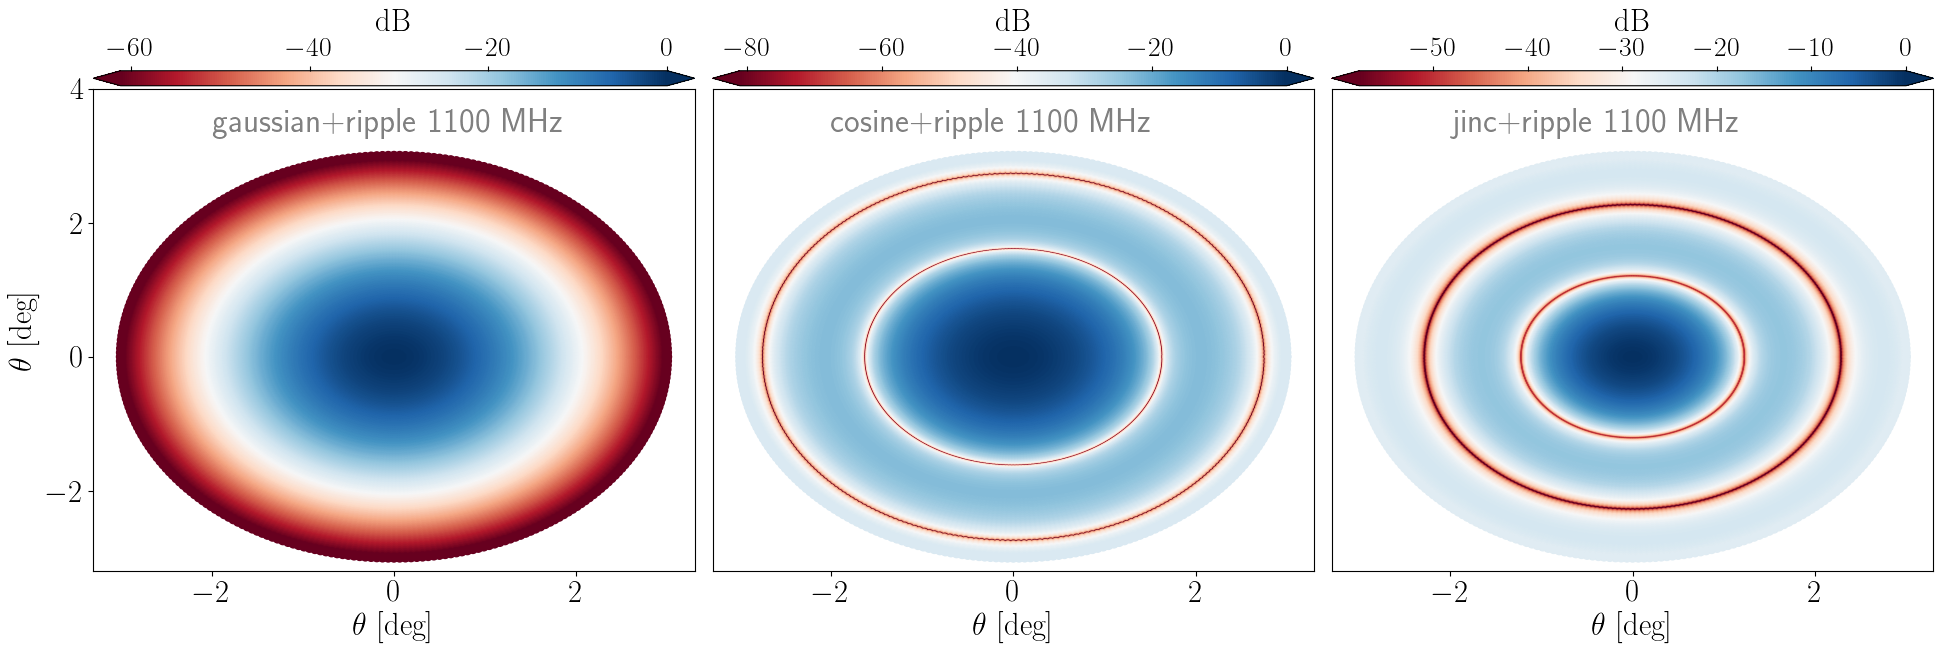

In [7]:
grid = plt.GridSpec(1,3,top=1.3,right=3*1.,wspace=0.03)
dtheta     = 0.01
theta     = np.arange(0,3+dtheta,dtheta) #deg
D = 13.5
source    = "meerkat" if D==13.5 else "bingo" if D==40. else "none"
fwhm_type = "ripple"
nu_ref    = 1100
for i,(type_,icmap) in enumerate(zip(['gaussian','cosine','jinc'],3*['RdBu'])):
    ax = plt.subplot(grid[0,i])
    ifwhm  = model.fwhm_modelling(nu=nu_ref,type_=fwhm_type, D=D, in_degree=True)
    bg     = model.beam_function(type_,fwhm=ifwhm, theta_=theta)
    beam = beam3D(beam_=bg, theta_=theta)
    im   = ax.scatter(beam['x'], beam['y'], c=beam['z'], cmap=icmap)
    ax.set_xlabel(r"$\theta\ [\textrm{deg}]$")
    if not i: ax.set_ylabel(r"$\theta\ [\textrm{deg}]$")
    if i: ax.set_yticks([]) 
    clb = plt.colorbar(im, ax=ax,extend='both',shrink=1.,pad=0.005,aspect=40,location="top")
    clb.set_label(r'$\textrm{dB}$', weight='bold')
    clb.ax.tick_params(labelsize=20) 
    ax.text(0-2,beam['y'].max()+0.35, r"{}+{} {} MHz".format(type_,fwhm_type,nu_ref), fontdict=font)    
    ax.set_ylim(beam['y'].min()-0.2,beam['y'].max()+1)
#ax.view_init(20.,90) 
plt.savefig("/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/outputs/{}.jpg".format('2dbeam_{}_{}__{}'.format(fwhm_type,nu_ref,source)), dpi=100, bbox_inches='tight')

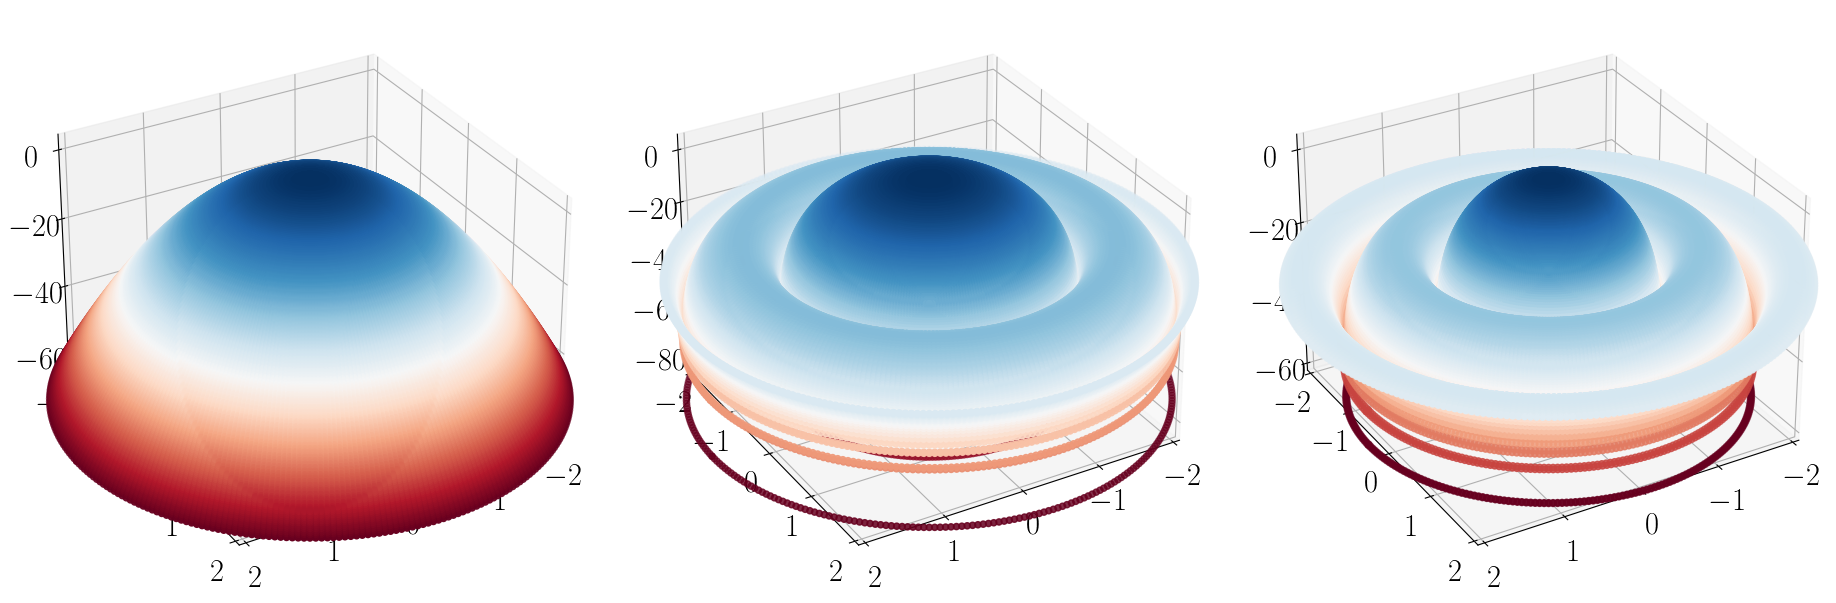

In [8]:
grid = plt.GridSpec(1,3,top=1.3,right=3*1.,wspace=0.03)
dtheta = 0.01
D = 13.5
source    = "meerkat" if D==13.5 else "bingo" if D==40. else "none"
fwhm_type = "ripple"
nu_ref    = 1100
theta  = np.arange(0,3+dtheta,dtheta) #deg
for i,(type_,icmap) in enumerate(zip(['gaussian','cosine','jinc'],3*['RdBu'])):
    ax = plt.subplot(grid[0,i],projection='3d')
    ifwhm  = model.fwhm_modelling(nu=nu_ref,type_=fwhm_type, D=D, in_degree=True)
    bg     = model.beam_function(type_,fwhm=ifwhm, theta_=theta)
    beam = beam3D(beam_=bg, theta_=theta)
    im   = ax.scatter(beam['x'], beam['y'], beam['z'], c=beam['z'], cmap=icmap)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.view_init(30.,60)     
plt.savefig("/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/outputs/{}.jpg".format('3dbeam_{}_{}__{}'.format(fwhm_type,nu_ref,source)), dpi=100, bbox_inches='tight')